In [1]:
import os, subprocess
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tempfile
tmpdir=tempfile.gettempdir()
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from PIL import Image
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.stats.weightstats as ws
import nibabel as nb
#from profile_surface import surface_smoothing

/home/users/kwagstyl/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/users/kwagstyl/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/users/kwagstyl/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/users/kwagstyl/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it wi

In [2]:
def surface_smoothing(values, surf_filename, fwhm=2):
    """smooth surface values using depth_potential. Will loop over multiple values if necessary
    smooths across surf_filename with fwhm set"""
    #check dimensions
    shrink=False
    flipped=False
    if np.ndim(values)==1:
        values=np.array([values])
        shrink=True
    elif values.shape[0]>values.shape[1]:
        values=values.T
        flipped=True
    new_values=np.zeros_like(values)
    for k,overlay in enumerate(values):
        np.savetxt('/tmp/tmp.txt', overlay, fmt='%.2f')
        print('smoothing surface '+str(k))
        subprocess.call('depth_potential -smooth '+ str(fwhm)+' /tmp/tmp.txt '+ surf_filename + ' /tmp/smtmp.txt',shell=True)
        new_overlay = np.loadtxt('/tmp/smtmp.txt')
        new_values[k] = new_overlay
    if shrink:
        return new_values[0]
    else:
        if flipped==True:
            return new_values.T
        return new_values

In [3]:
def plot_surface(overlay,surface_file,colourmap,min_val,max_val, mask=False,below_thresh=0.01):
    import io_mesh as io
    """ plot surface overlays using ray_trace,
    colourmap is matplotlib colourmap
    surface_file is obj file
    min_val and max_val have to be specified"""
    rand=str(np.random.randint(10000))
    if mask is not False:
        overlay[mask==1]=min_val-below_thresh
    #save two views
    surface=io.load_mesh_geometry(surface_file)
    colours=overlay2colours(overlay,colourmap,min_val,max_val)
    save_coloured_obj(os.path.join(tmpdir,rand+'tmp.obj'),surface['coords'],surface['faces'],colours)
    subprocess.call('ray_trace ' +  os.path.join(tmpdir, rand+'tmp.obj ' ) +'-bg white -sup 3 -crop -left -size 1000 1000 -output ' +  os.path.join(tmpdir, rand+'tmp_l.rgb' ),shell=True)
    subprocess.call('ray_trace ' +  os.path.join(tmpdir, rand+'tmp.obj ' ) +'-bg white -sup 3 -crop -right -size 1000 1000 -output ' +  os.path.join(tmpdir, rand+'tmp_r.rgb' ),shell=True)
    
    imagel=plt.imread( os.path.join(tmpdir, rand+'tmp_l.rgb' ))
    imager=plt.imread( os.path.join(tmpdir, rand+'tmp_r.rgb' ))
    return imagel,imager

def rescale_to_256(array,min_val,max_val):
    """ensure all values lie in range 0 - 255"""
    scaled=(array-min_val)/(max_val-min_val)
    #clip
    array_s=np.round(255*scaled).astype(int)
    return array_s

def rgb_matrix(cmap_name):
    colourmap=cm.get_cmap(cmap_name)
    c=np.zeros((256,4))
    for r in range(256):
        c[r]=list(colourmap(r))
    return c

def save_coloured_obj(surf_mesh,coords,faces,colours):
    """save obj file with coloured vertices
    surfmesh - filename obj
    coords - coordinates
    faces - triangle indices
    colours - n_vert x 4 matrix of colours rgb"""
#write out MNI - obj format
    n_vert=len(coords)
    norms=normal_vectors(coords,faces).tolist()
    XYZ=coords.tolist()
    Tri=faces.tolist()
    with open(surf_mesh,'w') as s:
        line1="P 0.3 0.3 0.4 10 1 " + str(n_vert) + "\n"
        s.write(line1)
        k=-1
        #save coordinates
        for a in XYZ:
            k+=1
            cor=' ' + ' '.join(list(map(str, XYZ[k])))
            s.write('%s\n' % cor)
        s.write('\n')
        #save normals
        for k,a in enumerate(XYZ):
            normal=' ' + ' '.join(list(map(str, norms[k])))
            s.write('%s\n' % normal)
        s.write('\n')
        l=' ' + str(len(Tri))+'\n'
        s.write(l)
        #2 indicates colours are done per vertex
        s.write(' 2\n')
        for colour in colours:
            col=' ' + ' '.join(list(map(str, colour)))
            s.write('%s\n' % col)
        s.write('\n')
        nt=len(Tri)*3
        Triangles=np.arange(3,nt+1,3)
        Rounded8=np.shape(Triangles)[0]/8
        N8=int(8*Rounded8)
        Triangles8=Triangles[0:N8]
        RowsOf8=np.split(Triangles8,N8/8)
        for r in RowsOf8:
            L=r.tolist()
            Lint=map(int,L)
            Line=' ' + ' '.join(map(str, Lint))
            s.write('%s\n' % Line)
        L=Triangles[N8:].tolist()
        Lint=map(int,L)
        Line=' ' + ' '.join(map(str, Lint))
        s.write('%s\n' % Line)
        s.write('\n')
        ListOfTriangles=np.array(Tri).flatten()
        Rounded8=np.shape(ListOfTriangles)[0]/8
        N8=int(8*Rounded8)
        Triangles8=ListOfTriangles[0:N8]
        ListTri8=ListOfTriangles[0:N8]
        RowsOf8=np.split(Triangles8,N8/8)
        for r in RowsOf8:
            L=r.tolist()
            Lint=map(int,L)
            Line=' ' + ' '.join(map(str, Lint))
            s.write('%s\n' % Line)
        L=ListOfTriangles[N8:].tolist()
        Lint=map(int,L)
        Line=' ' + ' '.join(map(str, Lint))
        s.write('%s\n' % Line)
        
        
def normal_vectors(vertices,faces):
    norm = np.zeros( vertices.shape, dtype=vertices.dtype )
    tris = vertices[faces]
    n = np.cross( tris[::,1 ] - tris[::,0]  , tris[::,2 ] - tris[::,0] )
    n=normalize_v3(n)
    norm[ faces[:,0] ] += n
    norm[ faces[:,1] ] += n
    norm[ faces[:,2] ] += n
    return normalize_v3(norm)


def normalize_v3(arr):
    ''' Normalize a numpy array of 3 component vectors shape=(n,3) '''
    lens = np.sqrt( arr[:,0]**2 + arr[:,1]**2 + arr[:,2]**2 )
    arr[:,0] /= lens
    arr[:,1] /= lens
    arr[:,2] /= lens                
    return arr

def overlay2colours(overlay,colourmap, min_val, max_val):
    """colour each vertex in an overlay
    below min_val is set to white (0,0,0,0). Above is clipped to max_val"""
    overlay_s=rescale_to_256(overlay,min_val,max_val)
    colours = rgb_matrix(colourmap)
    overlay_rgb=np.zeros((len(overlay),4))
    #set below thresh colours to white
    overlay_rgb[overlay_s<0]=np.array([1,1,1,1])
    overlay_s=np.clip(overlay_s, None, 255).astype(int)
    overlay_rgb[overlay_s>=0]=colours[overlay_s[overlay_s>=0]]
    return overlay_rgb


In [4]:
bar=np.reshape(rgb_matrix('viridis'),(256,1,4))
bar=np.vstack(([[[1,1,1,1]]],bar))
bar=np.repeat(bar,10,axis=1)


In [5]:
#v1 thickness
bil=[]
for hemi in ['left','right']:
    v1 = np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/geodesics/m1_'+hemi+'.txt')[:163842].astype(bool)
    thickness=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/thickness_'+hemi+'_total.txt')[:163842]
    bil.extend(np.sort(thickness[v1]))
    

print(bil[len(bil)//40],bil[39*len(bil)//40])
print(np.mean(bil),np.std(bil))

2.37108 3.15307
3.020330999574649 0.5081159719473511


In [6]:
#read in von economo values
ve_thickness=pd.read_excel('/data1/users/kwagstyl/bigbrain/NeuralNetworks/von_economo/Thickness_table.xlsx')

ve_parcellation=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/von_economo/lh.economo.label.rsled.txt').astype(int)
bb_thickness=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/thickness_left_total.txt')[:163842]
ve_thickness['bigbrain_thickness']=0
ve_thickness['bigbrain_area']=0


In [7]:
for layer in np.arange(6):
    print(np.mean(ve_thickness['ve_{}'.format(layer+1)][2:]),np.std(ve_thickness['ve_{}'.format(layer+1)][2:]))

0.2141860465116279 0.07761660569568064
0.1446511627906977 0.09104940742075797
0.725581395348837 0.35247498559163093
0.20325581395348832 0.1644401485836046
0.44255813953488377 0.21111104785579374
0.7341860465116278 0.36044696128324255


In [8]:
#tissue from crown_max, crown_min or wall or ve_total
tissue='crown_min'
rois_included=ve_thickness['label'][ve_thickness.loc[:,tissue]>0]
for roi in np.unique(ve_parcellation):
    if ve_thickness.loc[roi,tissue]>0:
        ve_thickness.loc[roi,'bigbrain']=np.mean(bb_thickness[ve_parcellation==roi])
        ve_thickness.loc[roi,'area']=np.sum(ve_parcellation==roi)
        #rois_included.append(roi)

In [9]:
#print(stats.pearsonr(ve_thickness[tissue][rois_included],ve_thickness['bigbrain'][rois_included]))
#sns.regplot(ve_thickness[tissue][rois_included],ve_thickness['bigbrain'][rois_included],
 #          scatter_kws={'s': ve_thickness['area'][rois_included]/100})

def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

R=corr(ve_thickness[tissue][rois_included],np.array(ve_thickness['bigbrain'][rois_included]),
                             ve_thickness['area'][rois_included])

print(R)

0.8581294083060543


smoothing surface 0


KeyboardInterrupt: 

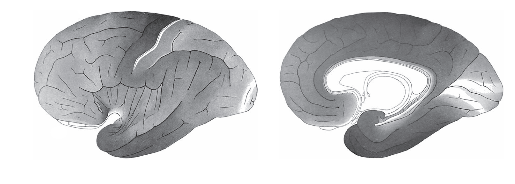

In [10]:
hemis=['left','right']
ncol=4
nrow=4
fig = plt.figure(figsize=(10, 11)) 
gs = gridspec.GridSpec(nrow, ncol, width_ratios=np.ones(ncol), #height_ratios=[1,0.1],
         wspace=0.05, hspace=0, left=0.17, right=0.845)
#gs.tight_layout(fig)
min_val=1
max_val=4
ve_lat=Image.open('/data1/users/kwagstyl/bigbrain/Hierarchy/Total_thickness_lateral.tiff')
ve_med=Image.open('/data1/users/kwagstyl/bigbrain/Hierarchy/Total_thickness_medial.tiff')
ax= plt.subplot(gs[0,0:2])
ax.imshow(ve_lat)
ax.axis('off')
ax= plt.subplot(gs[0,2:4])
ax.imshow(ve_med)
ax.axis('off')

for k,hemi in enumerate(hemis):
    overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/thickness_'+hemi+'_total.txt')[:163842]
    surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatwhite_'+hemi+'_327680.obj'
    mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/medial_wall_'+hemi+'.txt')[:163842]
    overlay=surface_smoothing(overlay, surface_file,3)
    surface_plots = plot_surface(overlay, surface_file,'viridis',mask=mask, min_val=min_val, max_val=max_val)
    ax= plt.subplot(gs[k+1,0:2])
    ax.imshow(surface_plots[1-np.abs(k-1)])
    ax.axis('off')
    ax= plt.subplot(gs[k+1,2:4])
    ax.imshow(surface_plots[np.abs(k-1)])
    ax.axis('off')
    
    

ax= plt.subplot(gs[3,1:3])
ax.imshow(np.rot90(bar))
#ax.axis('off')
ax.set_yticks([])
ax.set_xticks([0,128,256])
ax.set_xticklabels([np.round(min_val,decimals=2),np.mean([min_val,max_val]),np.round(max_val,decimals=2)],size=25)
ax.set_title('Cortical thickness (mm)', size=25)
fig.savefig('/data1/users/kwagstyl/bigbrain/NeuralNetworks/figs/total_thickness_plus_ve.pdf',bbox_inches='tight')

In [31]:
np.sum(mask[ve_parcellation==roi])

0.0

smoothing surface 0
smoothing surface 0


/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


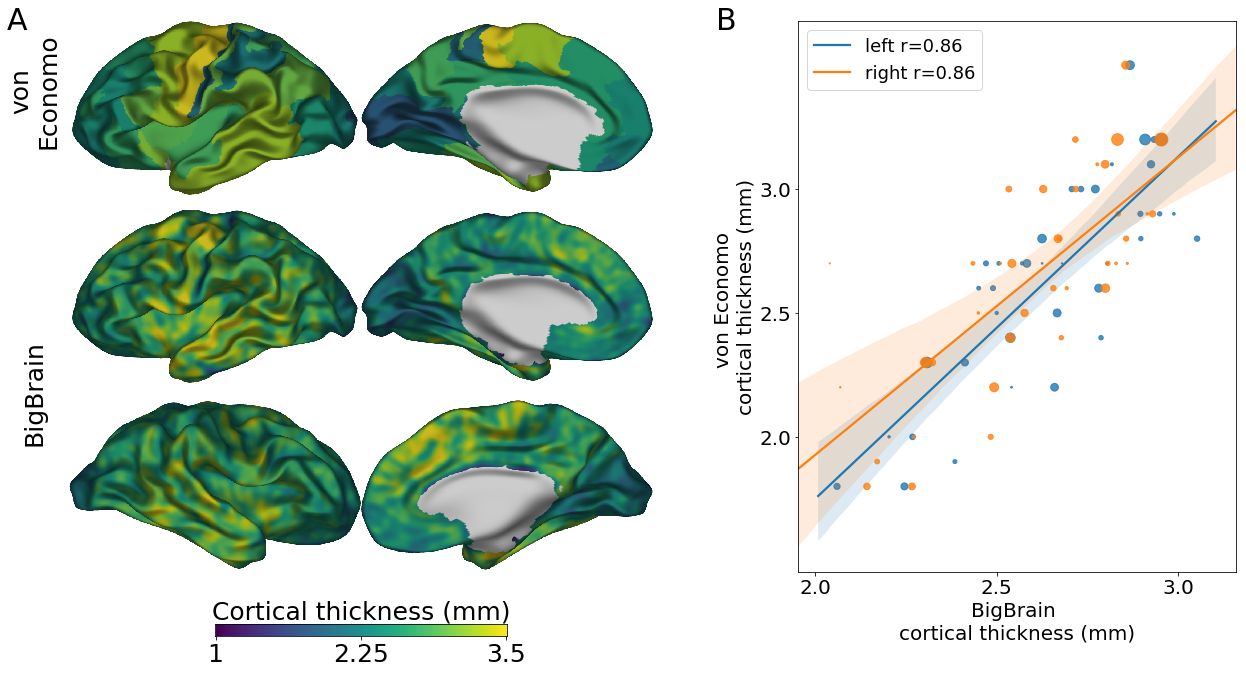

In [11]:
#plotting vs von Economo on surfaces
hemis=['left','right']
hemis_fs=['lh','rh']
ncol=8
nrow=4
fig = plt.figure(figsize=(24, 12)) 
gs = gridspec.GridSpec(nrow, ncol, width_ratios=np.ones(ncol),height_ratios=[1,1,1,0.5], #height_ratios=[1,0.1],
         wspace=0.0, hspace=0.1, left=0.17, right=0.845)
gs.tight_layout(fig)
min_val=1
max_val=3.5
ve_thickness=pd.read_excel('/data1/users/kwagstyl/bigbrain/NeuralNetworks/von_economo/Thickness_table.xlsx')
#choose between 'crown_min', 'wall', 've_sum', 'crown_max'
tissue='crown_min'
font = {'family' : 'sans-serif',
        'style':'normal',
        'size'   : 35}

for k,hemi in enumerate(hemis):
    overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/thickness_'+hemi+'_total.txt')[:163842]
    surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatter_white_'+hemi+'_327680.obj'
    mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/medial_wall_'+hemi+'.txt')[:163842]
    overlay=surface_smoothing(overlay, surface_file,3)
    surface_plots = plot_surface(overlay, surface_file,'viridis',mask=mask, min_val=min_val, max_val=max_val)
    ax= plt.subplot(gs[1+k,0:2])
    ax.imshow(surface_plots[1-np.abs(k-1)])

    ax.axis('off')
    ax= plt.subplot(gs[1+k,2:4])
    ax.imshow(surface_plots[np.abs(k-1)])
    ax.axis('off')


    
legend_text=[[],[]]
for k,hemi in enumerate(hemis):
    #read in von economo values
    ve_parcellation=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/von_economo/'+hemis_fs[k]+'.economo.label.rsled.txt').astype(int)
    bb_thickness=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/thickness_'+hemi+'_total.txt')[:163842]
    mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/medial_wall_'+hemi+'.txt')[:163842]
    ve_overlay=np.zeros_like(bb_thickness)
    ve_thickness['bigbrain_thickness']=0
    ve_thickness['bigbrain_area']=0
    rois_included=ve_thickness['label'][ve_thickness.loc[:,tissue]>0]
    rois_included=[]
    for roi in np.unique(ve_parcellation):
        #exclude if fewer that 50 vertices
        if np.sum(ve_parcellation==roi)>50 and ve_thickness.loc[roi,tissue]>0:
            rois_included.append(roi)
            ve_thickness.loc[roi,'bigbrain']=np.mean(bb_thickness[np.logical_and(ve_parcellation==roi,mask==0)])
            ve_thickness.loc[roi,'area']=np.sum(ve_parcellation==roi)
            ve_overlay[ve_parcellation==roi]=ve_thickness.loc[roi,tissue]
    rois_included=np.array(rois_included)
    surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatter_white_'+hemi+'_327680.obj'
    #mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/medial_wall_'+hemi+'.txt')[:163842]
    if hemi=='left':
        surface_plots = plot_surface(ve_overlay, surface_file,'viridis', min_val=min_val, max_val=max_val)
        ax= plt.subplot(gs[0,4*k:4*k+2])
        ax.imshow(surface_plots[1-np.abs(k-1)])
        ax.axis('off')

        ax= plt.subplot(gs[0,4*k+2:4*k+4])
        ax.imshow(surface_plots[np.abs(k-1)])
        ax.axis('off')  
    ax1= plt.subplot(gs[:-1,5:])
    sns.regplot(ve_thickness['bigbrain'][rois_included],ve_thickness[tissue][rois_included],
           scatter_kws={'s': ve_thickness['area'][rois_included]/100},ax=ax1)
    
    #to plot labels of diffs
    
    diffs=ve_thickness[tissue][rois_included]-ve_thickness['bigbrain'][rois_included]
    big_diffs=np.abs(diffs)>0.5
 #   for roi in rois_included[big_diffs]:
 #       ax1.text(ve_thickness[tissue][roi],ve_thickness['bigbrain'][roi],ve_thickness['area_name'][roi])

    #area weighted pearson r
    #r,p=stats.pearsonr(ve_thickness[tissue][rois_included],ve_thickness['bigbrain'][rois_included])
    r=corr(ve_thickness[tissue][rois_included],ve_thickness['bigbrain'][rois_included],ve_thickness['area'][rois_included])
   #ax1.set(xlabel='von Economo \ncortical thickness (mm)',ylabel='BigBrain \ncortical thickness (mm)')
    ax1.set_ylabel('von Economo \ncortical thickness (mm)',fontsize=20)
    ax1.set_xlabel('BigBrain \ncortical thickness (mm)',fontsize=20)
    ax1.set_yticks([2.0,2.5,3.0]) 
    ax1.set_xticks([2.0,2.5,3.0])
    ax1.set_yticklabels([2.0,2.5,3.0],fontsize=20) 
    ax1.set_xticklabels([2.0,2.5,3.0],fontsize=20)
    legend_text[k]=hemi+' r={:.2f}'.format(r)
    if k==1:
        ax1.legend(legend_text,loc='upper left',prop={'size': 18})

plt.figtext(0.15,0.8,'von\nEconomo',ha="center",va="center",size=25,rotation=90)
plt.figtext(0.15,0.45,'BigBrain',ha="center",va="center",size=25,rotation=90)
plt.figtext(0.14,0.88,'A',ha="center",va="center",size=30)
plt.figtext(0.55,0.88,'B',ha="center",va="center",size=30)


ax= plt.subplot(gs[3,1:3])
ax.imshow(np.rot90(bar))
ax.set_yticks([])
ax.set_xticks([0,128,256])
ax.set_xticklabels([np.round(min_val,decimals=2),np.mean([min_val,max_val]),np.round(max_val,decimals=2)],size=25)
ax.set_title('Cortical thickness (mm)', size=25)
fig.savefig('/data1/users/kwagstyl/bigbrain/NeuralNetworks/figs/total_thickness_plus_ve_surfs.pdf',bbox_inches='tight')

smoothing surface 0
smoothing surface 0


/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setti

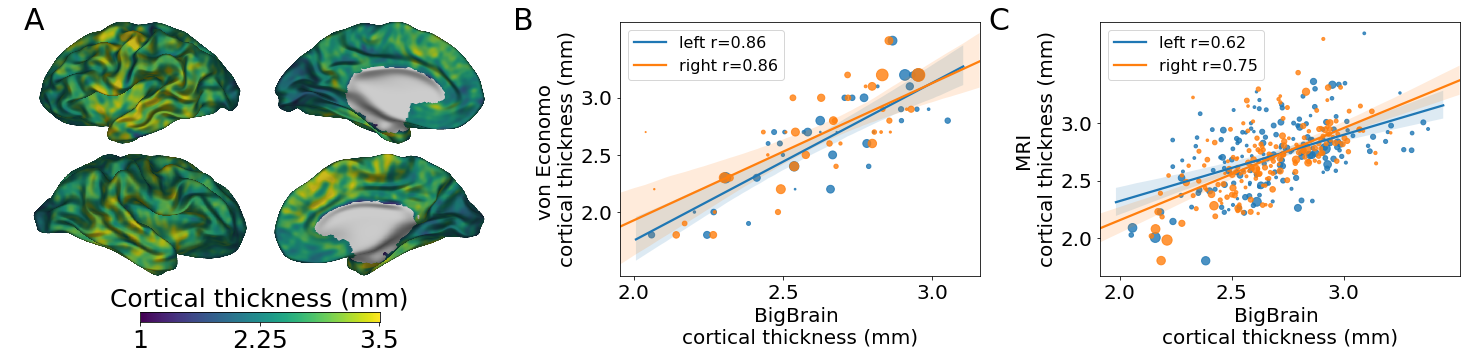

In [12]:
#plotting vs von Economo on surfaces
hemis=['left','right']
hemis_fs=['lh','rh']
ncol=12
nrow=3
fig = plt.figure(figsize=(20, 6)) 
gs = gridspec.GridSpec(nrow, ncol, width_ratios=np.ones(ncol),height_ratios=[1,1,0.5], #height_ratios=[1,0.1],
         wspace=0.0, hspace=0.1, left=0, right=1)
gs.tight_layout(fig)
min_val=1
max_val=3.5
ve_thickness=pd.read_excel('/data1/users/kwagstyl/bigbrain/NeuralNetworks/von_economo/Thickness_table.xlsx')
#choose between 'crown_min', 'wall', 've_sum', 'crown_max'
tissue='crown_min'
font = {'family' : 'sans-serif',
        'style':'normal',
        'size'   : 35}

for k,hemi in enumerate(hemis):
    overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/thickness_'+hemi+'_total.txt')[:163842]
    surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatter_white_'+hemi+'_327680.obj'
    mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/medial_wall_'+hemi+'.txt')[:163842]
    overlay=surface_smoothing(overlay, surface_file,3)
    surface_plots = plot_surface(overlay, surface_file,'viridis',mask=mask, min_val=min_val, max_val=max_val)
    ax= plt.subplot(gs[k,0:2])
    ax.imshow(surface_plots[1-np.abs(k-1)])

    ax.axis('off')
    ax= plt.subplot(gs[k,2:4])
    ax.imshow(surface_plots[np.abs(k-1)])
    ax.axis('off')


    
legend_text=[[],[]]
for k,hemi in enumerate(hemis):
    #read in von economo values
    ve_parcellation=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/von_economo/'+hemis_fs[k]+'.economo.label.rsled.txt').astype(int)
    bb_thickness=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/thickness_'+hemi+'_total.txt')[:163842]
    mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/medial_wall_'+hemi+'.txt')[:163842]
    ve_overlay=np.zeros_like(bb_thickness)
    ve_thickness['bigbrain_thickness']=0
    ve_thickness['bigbrain_area']=0
    rois_included=ve_thickness['label'][ve_thickness.loc[:,tissue]>0]
    rois_included=[]
    for roi in np.unique(ve_parcellation):
        #exclude if fewer that 50 vertices
        if np.sum(ve_parcellation==roi)>50 and ve_thickness.loc[roi,tissue]>0:
            rois_included.append(roi)
            ve_thickness.loc[roi,'bigbrain']=np.mean(bb_thickness[np.logical_and(ve_parcellation==roi,mask==0)])
            ve_thickness.loc[roi,'area']=np.sum(ve_parcellation==roi)
            ve_overlay[ve_parcellation==roi]=ve_thickness.loc[roi,tissue]
    rois_included=np.array(rois_included)
    surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatter_white_'+hemi+'_327680.obj'
    #mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/medial_wall_'+hemi+'.txt')[:163842]
#     if hemi=='left':
#         surface_plots = plot_surface(ve_overlay, surface_file,'viridis', min_val=min_val, max_val=max_val)
#         ax= plt.subplot(gs[0,4*k:4*k+2])
#         ax.imshow(surface_plots[1-np.abs(k-1)])
#         ax.axis('off')

#         ax= plt.subplot(gs[0,4*k+2:4*k+4])
#         ax.imshow(surface_plots[np.abs(k-1)])
#         ax.axis('off')  
    ax1= plt.subplot(gs[:-1,5:8])
    sns.regplot(ve_thickness['bigbrain'][rois_included],ve_thickness[tissue][rois_included],
           scatter_kws={'s': ve_thickness['area'][rois_included]/100},ax=ax1)
    
    #to plot labels of diffs
    
    diffs=ve_thickness[tissue][rois_included]-ve_thickness['bigbrain'][rois_included]
    big_diffs=np.abs(diffs)>0.5
 #   for roi in rois_included[big_diffs]:
 #       ax1.text(ve_thickness[tissue][roi],ve_thickness['bigbrain'][roi],ve_thickness['area_name'][roi])

    #area weighted pearson r
    #r,p=stats.pearsonr(ve_thickness[tissue][rois_included],ve_thickness['bigbrain'][rois_included])
    r=corr(ve_thickness[tissue][rois_included],ve_thickness['bigbrain'][rois_included],ve_thickness['area'][rois_included])
   #ax1.set(xlabel='von Economo \ncortical thickness (mm)',ylabel='BigBrain \ncortical thickness (mm)')
    ax1.set_ylabel('von Economo \ncortical thickness (mm)',fontsize=20)
    ax1.set_xlabel('BigBrain \ncortical thickness (mm)',fontsize=20)
    ax1.set_yticks([2.0,2.5,3.0]) 
    ax1.set_xticks([2.0,2.5,3.0])
    ax1.set_yticklabels([2.0,2.5,3.0],fontsize=20) 
    ax1.set_xticklabels([2.0,2.5,3.0],fontsize=20)
    legend_text[k]=hemi+' r={:.2f}'.format(r)
    if k==1:
        ax1.legend(legend_text,loc='upper left',prop={'size': 16})
    
   #HCP plot
    
ax2 = plt.subplot(gs[:-1,9:])
fs_hemi=['lh','rh']
mean_bb={}
hcp_dir='/data1/users/kwagstyl/bigbrain/NeuralNetworks/hcp/'
annot=nb.load(os.path.join(hcp_dir,'Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii'))
annotation=annot.get_data().ravel()[:]
thickness = nb.load(os.path.join(hcp_dir,'S1200.corrThickness_MSMAll.32k_fs_LR.dscalar.nii'))
mean_hcp={}
_,areas=np.unique(annotation,return_counts=True)
for k,hemi in enumerate(hemis):
    #read in von economo values
    hcp_parcellation=np.loadtxt('../../data_4_sharing/equivolume_profiles/'+fs_hemi[k]+'.HCP-MMP-1.0.label.txt').astype(int)

    bb_thickness=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/thickness_'+hemi+'_total.txt')[:163842]
    mean_bb[hemi]=[]
    for roi in np.unique(hcp_parcellation)[1:]:
        mean_bb[hemi].append(np.mean(bb_thickness[hcp_parcellation==roi]))    
    mean_hcp[hemi]=[]
    for roi in np.arange(180)+180*k+1:
        mean_hcp[hemi].append(np.mean(thickness.dataobj[:].ravel()[annotation==roi]))
    
    sns.regplot(mean_bb[hemi],mean_hcp[hemi],scatter_kws={'s': areas[np.arange(180)+180*k]/8},ax=ax2)
    r=corr(mean_hcp[hemi],mean_bb[hemi],areas[np.arange(180)+180*k])
    ax2.set_ylabel('MRI \ncortical thickness (mm)',fontsize=20)
    ax2.set_xlabel('BigBrain \ncortical thickness (mm)',fontsize=20)
    ax2.set_yticks([2.0,2.5,3.0]) 
    ax2.set_xticks([2.0,2.5,3.0])
    ax2.set_yticklabels([2.0,2.5,3.0],fontsize=20) 
    ax2.set_xticklabels([2.0,2.5,3.0],fontsize=20)
    legend_text[k]=hemi+' r={:.2f}'.format(r)
    
    if k==1:
        ax2.legend(legend_text,loc='upper left',prop={'size': 16})

 
#plt.figtext(0.15,0.8,'von\nEconomo',ha="center",va="center",size=25,rotation=90)
#plt.figtext(0.15,0.45,'BigBrain',ha="center",va="center",size=25,rotation=90)
plt.figtext(0.01,0.88,'A',ha="center",va="center",size=30)
plt.figtext(0.35,0.88,'B',ha="center",va="center",size=30)
plt.figtext(0.68,0.88,'C',ha="center",va="center",size=30)




ax= plt.subplot(gs[2,1:3])
ax.imshow(np.rot90(bar))
ax.set_yticks([])
ax.set_xticks([0,128,256])
ax.set_xticklabels([np.round(min_val,decimals=2),np.mean([min_val,max_val]),np.round(max_val,decimals=2)],size=25)
ax.set_title('Cortical thickness (mm)', size=25)
fig.savefig('/data1/users/kwagstyl/bigbrain/NeuralNetworks/figs/total_thickness_plus_ve_mri_surfs.pdf',bbox_inches='tight')

/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


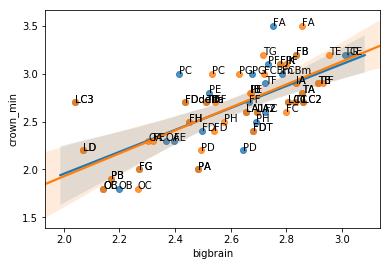

In [104]:

ax=plt.subplot()
for k,hemi in enumerate(hemis):
    bb_thickness=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/thickness_'+hemi+'_total.txt')[:163842]
    ve_overlay=np.zeros_like(bb_thickness)
    ve_thickness['bigbrain_thickness']=0
    ve_thickness['bigbrain_area']=0
    rois_included=ve_thickness['label'][ve_thickness.loc[:,tissue]>0]
    for roi in np.unique(ve_parcellation):
        if np.sum(ve_parcellation==roi)>3000 and ve_thickness.loc[roi,tissue]>0:
            ve_thickness.loc[roi,'bigbrain']=np.mean(bb_thickness[ve_parcellation==roi])
            ve_thickness.loc[roi,'area']=np.sum(ve_parcellation==roi)
    sns.regplot(ve_thickness['bigbrain'][rois_included],ve_thickness[tissue][rois_included])

    for roi in rois_included:
        ax.text(ve_thickness['bigbrain'][roi],ve_thickness[tissue][roi],ve_thickness['area_name'][roi],)



In [105]:
tissue

'crown_min'

/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[[0.49663861 0.45653834]
 [0.11189045 0.0649399 ]
 [0.73631071 0.7153212 ]
 [0.79848507 0.76226801]
 [0.66119911 0.65823614]
 [0.65598746 0.60487137]]


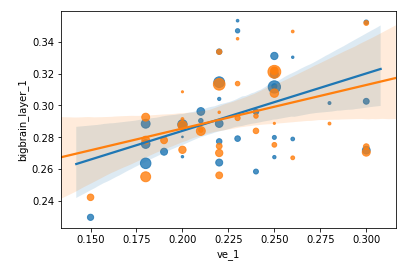

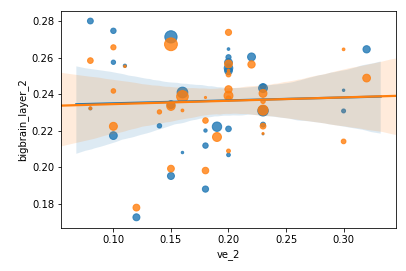

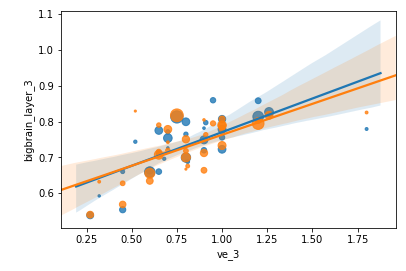

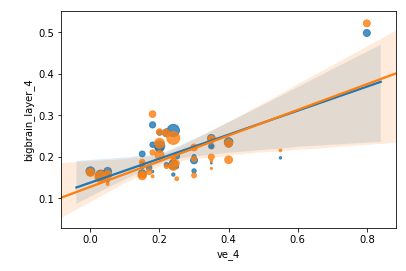

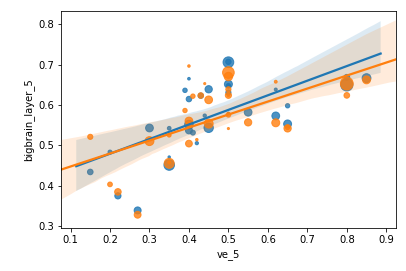

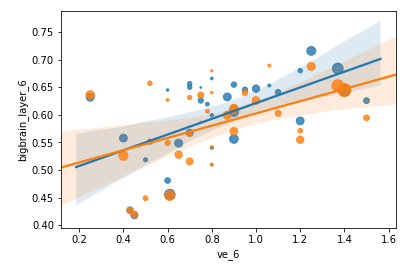

In [13]:
r=np.zeros((6,2))
for layer in range(6):
    plt.figure()
    for k,hemi in enumerate(hemis):
        tissue='ve_'+str(layer+1)
        ve_parcellation=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/von_economo/'+hemis_fs[k]+'.economo.label.rsled.txt').astype(int)
        bb_thickness=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/thickness_'+hemi+'_layer'+str(layer+1)+'.txt')[:163842]
        surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatwhite_'+hemi+'_327680.obj'
        mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/archi_'+hemi+'.txt')
        ve_overlay=np.zeros_like(bb_thickness)
        ve_thickness['bigbrain_layer_'+str(layer+1)]=0
        ve_thickness['bigbrain_area']=0
        rois_included=ve_thickness['label'][np.logical_and(ve_thickness.loc[:,'wall']>0,ve_thickness.loc[:,'ve_2'])]
        for roi in np.unique(ve_parcellation):
            if ve_thickness.loc[roi,'wall']>0:
                ve_thickness.loc[roi,'bigbrain_layer_'+str(layer+1)]=np.mean(bb_thickness[np.logical_and(ve_parcellation==roi,mask==0)])
                ve_thickness.loc[roi,'area']=np.sum(ve_parcellation==roi)
                ve_overlay[ve_parcellation==roi]=ve_thickness.loc[roi,tissue]
        r[layer,k]=corr(ve_thickness[tissue][rois_included],ve_thickness['bigbrain_layer_'+str(layer+1)][rois_included],ve_thickness['area'][rois_included])
        sns.regplot(ve_thickness[tissue][rois_included],ve_thickness['bigbrain_layer_'+str(layer+1)][rois_included],
           scatter_kws={'s': ve_thickness['area'][rois_included]/100})
        for roi in rois_included:
            plt.annotate(ve_thickness['area_name'][roi],[ve_thickness[tissue][roi],ve_thickness['bigbrain'][roi]])

print(r)

0 0
smoothing surface 0
smoothing surface 0
4 0
smoothing surface 0
smoothing surface 0
8 0
smoothing surface 0
smoothing surface 0
0 4
smoothing surface 0
smoothing surface 0
4 4
smoothing surface 0
smoothing surface 0
8 4
smoothing surface 0
smoothing surface 0


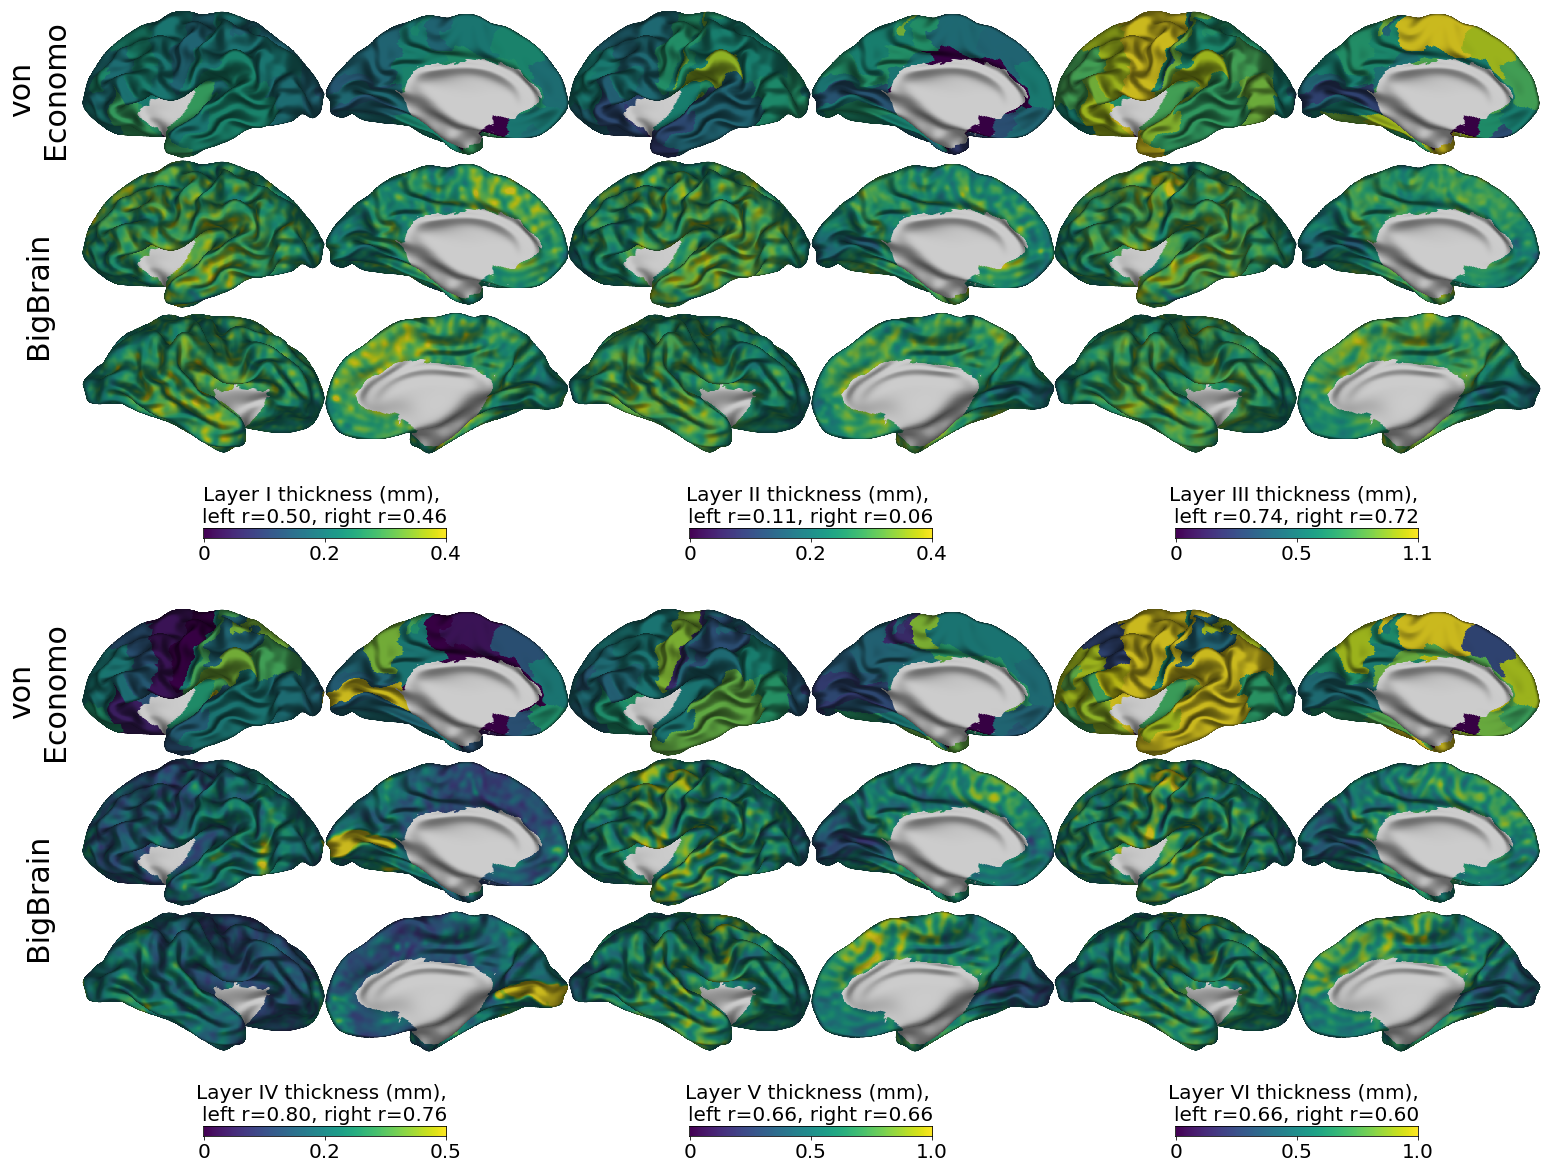

In [14]:
#figure plots with von Economo and V1 label
hemis=['left','right']
hemis_fs=['lh','rh']

ncol=12
nrow=8
fig = plt.figure(figsize=(30, 22)) 
gs = gridspec.GridSpec(nrow, ncol,  #height_ratios=[10,1,10,1],
         wspace=0.05, hspace=0.04, left=0.17, right=0.845)
#gs.tight_layout(fig)
gs.update(wspace=0, hspace=0)
minmax_fixed=False
#all_overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/confidence/confidenceleft_20.txt')[:163842]
titles=[
    
    'Layer I',
    'Layer II',
    'Layer III',
    'Layer IV',
    'Layer V',
    'Layer VI',
]
bar=np.reshape(rgb_matrix('viridis'),(256,1,4))
bar=np.vstack(([[[1,1,1,1]]],bar))
bar=np.repeat(bar,10,axis=1)

plt.figtext(0.15,0.83,'von\nEconomo',ha="center",va="center",size=30,rotation=90)
plt.figtext(0.15,0.7,'BigBrain',ha="center",va="center",size=30,rotation=90)


plt.figtext(0.15,0.45,'von\nEconomo',ha="center",va="center",size=30,rotation=90)
plt.figtext(0.15,0.32,'BigBrain',ha="center",va="center",size=30,rotation=90)

for layer in range(6):
    c=4*(layer%3)
    ro=4*(layer//3)
    print(c,ro)
    
    for k,hemi in enumerate(hemis):
        overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/thickness_'+hemi+'_layer'+str(layer+1)+'.txt')[:163842]
        surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatter_white_'+hemi+'_327680.obj'
        mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/archi_'+hemi+'.txt')   
        overlay=surface_smoothing(overlay, surface_file,3)
        if k ==0:
            mu=np.mean(overlay[mask!=1])
            sigma=np.std(overlay[mask!=1])
            min_val=0# mu-3.2*sigma
            if min_val<0:
                min_val=0
            max_val=mu+3.2*sigma    
        if minmax_fixed:
            min_val=0.1
            max_val=1.0
        #plotting ve surfaces
        if hemi=='left':
            tissue='ve_'+str(layer+1)
            ve_parcellation=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/von_economo/'+hemis_fs[k]+'.economo.label.rsled.txt').astype(int)
            bb_thickness=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/thickness_'+hemi+'_layer'+str(layer+1)+'.txt')[:163842]
            surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatter_white_'+hemi+'_327680.obj'
            ve_overlay=np.zeros_like(bb_thickness)
            ve_thickness['bigbrain_layer_'+str(layer+1)]=0
            ve_thickness['bigbrain_area']=0
            rois_included=ve_thickness['label'][ve_thickness.loc[:,'wall']>0]
            for roi in np.unique(ve_parcellation):
                if ve_thickness.loc[roi,'wall']>0:
                    ve_thickness.loc[roi,'bigbrain_layer_'+str(layer+1)]=np.mean(bb_thickness[ve_parcellation==roi])
                    ve_thickness.loc[roi,'area']=np.sum(ve_parcellation==roi)
                    ve_overlay[ve_parcellation==roi]=ve_thickness.loc[roi,tissue]
            surface_plots = plot_surface(ve_overlay, surface_file,'viridis',mask=mask, min_val=min_val, max_val=max_val)
            ax= plt.subplot(gs[ro,c:c+2])
            ax.imshow(surface_plots[1-np.abs(k-1)])
            ax.axis('off')
            ax= plt.subplot(gs[ro,c+2:c+4])
            ax.imshow(surface_plots[np.abs(k-1)])
            ax.axis('off')
        
        #print(stats.pearsonr(ve_thickness[tissue][rois_included],ve_thickness['bigbrain_layer_'+str(layer+1)][rois_included]))
        
        #plotting bigbrain surfaces
        surface_plots = plot_surface(overlay, surface_file,'viridis',mask=mask, min_val=min_val, max_val=max_val)
        ax= plt.subplot(gs[ro+k+1,c:c+2])
        ax.imshow(surface_plots[1-np.abs(k-1)])
        ax.axis('off')
        ax= plt.subplot(gs[ro+k+1,c+2:c+4])
        ax.imshow(surface_plots[np.abs(k-1)])
        ax.axis('off')
    
    ax= plt.subplot(gs[ro+3,c+1:c+3])
    ax.imshow(np.rot90(bar))
    #ax.axis('off')
    ax.set_yticks([])
    ax.set_xticks([0,128,256])
    ax.set_xticklabels([np.round(min_val,decimals=1),np.round(np.mean([min_val,max_val]),decimals=1),np.round(max_val,decimals=1)] ,size=20)
    ax.set_title(titles[layer]+' thickness (mm), \nleft r={:.2f}, right r={:.2f}'.format(r[layer,0],r[layer,1]), size=20)
    
fig.savefig('/data1/users/kwagstyl/bigbrain/NeuralNetworks/figs/layer_thickness_plus_vonE_surfs.eps',bbox_inches='tight')


In [18]:
#tidy dataframe for saving
clean=ve_thickness.dropna()
clean=clean.drop(columns=['label','wall','crown_max','bigbrain_thickness','bigbrain_area'])
clean= clean.round(decimals=2)

clean.to_csv('../../data_4_sharing/BigBrain_vE.csv')

In [17]:
clean

,area_name,crown_min,ve_1,ve_2,ve_3,ve_4,ve_5,ve_6,ve_sum,bigbrain,area,bigbrain_layer_1,bigbrain_layer_2,bigbrain_layer_3,bigbrain_layer_4,bigbrain_layer_5,bigbrain_layer_6
2,FA,3.5,0.18,0.23,1.26,0.00,0.85,1.25,3.77,2.86,7855.0,0.29,0.24,0.83,0.17,0.67,0.72
3,FB,3.2,0.22,0.16,1.20,0.03,0.50,1.37,3.48,2.83,11497.0,0.31,0.24,0.81,0.16,0.71,0.68
4,FC,2.6,0.25,0.15,1.00,0.15,0.50,0.25,2.30,2.80,6371.0,0.32,0.23,0.78,0.16,0.65,0.63
5,FCBm,3.0,0.24,0.18,1.00,0.17,0.43,0.95,2.97,2.72,2960.0,0.30,0.21,0.76,0.17,0.62,0.65
6,FD,2.4,0.20,0.19,0.80,0.24,0.45,0.90,2.78,2.54,8880.0,0.29,0.22,0.70,0.18,0.54,0.61
7,FDdelta,2.7,0.26,0.20,0.81,0.25,0.35,0.78,2.65,2.43,1376.0,0.28,0.21,0.69,0.18,0.54,0.62
8,FDT,2.4,0.21,0.14,0.91,0.22,0.39,0.70,2.57,2.68,2007.0,0.29,0.22,0.80,0.18,0.64,0.66
9,FE,2.3,0.22,0.15,0.60,0.30,0.40,0.70,2.37,2.32,4918.0,0.26,0.20,0.66,0.19,0.54,0.57
10,FF,2.7,0.30,0.10,1.00,0.05,0.62,0.87,2.94,2.54,6047.0,0.27,0.22,0.72,0.17,0.57,0.63
11,FG,2.0,0.20,0.16,0.32,0.18,0.35,0.80,2.01,2.27,612.0,0.27,0.21,0.59,0.16,0.47,0.51


0 0
smoothing surface 0
smoothing surface 0
4 0
smoothing surface 0
smoothing surface 0
8 0
smoothing surface 0
smoothing surface 0
0 4
smoothing surface 0
smoothing surface 0
4 4
smoothing surface 0
smoothing surface 0
8 4
smoothing surface 0
smoothing surface 0


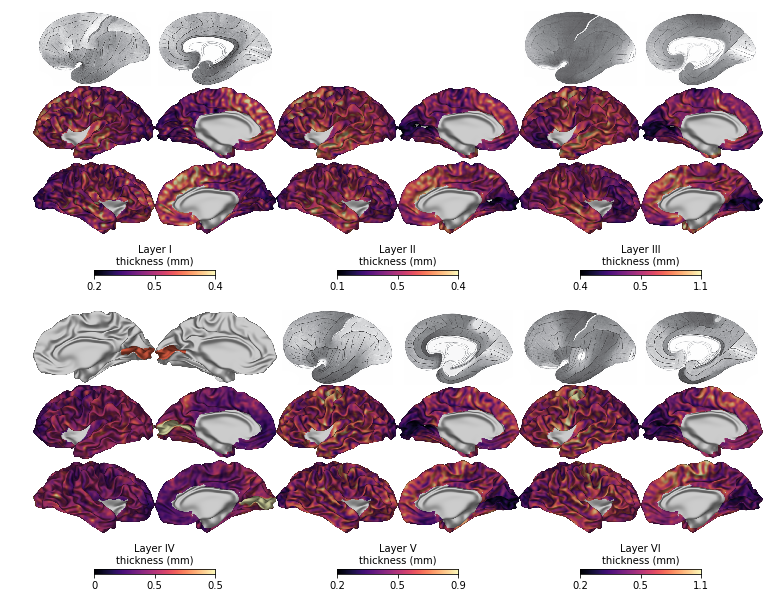

In [33]:
#figure plots with von Economo and V1 label
hemis=['left','right']

ncol=12
nrow=8
fig = plt.figure(figsize=(15, 11)) 
gs = gridspec.GridSpec(nrow, ncol,  #height_ratios=[10,1,10,1],
         wspace=0.05, hspace=0.04, left=0.17, right=0.845)
#gs.tight_layout(fig)
gs.update(wspace=0, hspace=0)
minmax_fixed=False
#all_overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/confidence/confidenceleft_20.txt')[:163842]
titles=[
    
    'Layer I',
    'Layer II',
    'Layer III',
    'Layer IV',
    'Layer V',
    'Layer VI',
]
bar=np.reshape(rgb_matrix('viridis'),(256,1,4))
bar=np.vstack(([[[1,1,1,1]]],bar))
bar=np.repeat(bar,10,axis=1)

for layer in range(6):
    c=4*(layer%3)
    ro=4*(layer//3)
    print(c,ro)
    if os.path.isfile('/data1/users/kwagstyl/bigbrain/Hierarchy/Layer'+str(layer+1)+'_lateral.tiff'):
        ve_lat=Image.open('/data1/users/kwagstyl/bigbrain/Hierarchy/Layer'+str(layer+1)+'_lateral.tiff')
        ve_med=Image.open('/data1/users/kwagstyl/bigbrain/Hierarchy/Layer'+str(layer+1)+'_medial.tiff')
        ax= plt.subplot(gs[ro,c:c+2])
        ax.imshow(ve_lat)
        ax.axis('off')
        ax= plt.subplot(gs[ro,c+2:c+4])
        ax.imshow(ve_med)
        ax.axis('off')
    elif layer ==3:
         #plot layer IV surfaces
        for k,hemi in enumerate(hemis):
            overlay = np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/geodesics/v1_'+hemi+'.txt')[:163842]
            surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatwhite_'+hemi+'_327680.obj'
            mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/archi_'+hemi+'.txt')  
            surface_plots = plot_surface(overlay, surface_file,'Reds',mask=mask, min_val=0.5, max_val=1.5)
            ax= plt.subplot(gs[ro,c+np.abs(k-1)*2:c+2+np.abs(k-1)*2])
            ax.imshow(surface_plots[np.abs(k-1)])
            ax.axis('off')
    for k,hemi in enumerate(hemis):
        overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/thickness_'+hemi+'_layer'+str(layer+1)+'.txt')[:163842]
        surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatwhite_'+hemi+'_327680.obj'
        mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/archi_'+hemi+'.txt')   
        overlay=surface_smoothing(overlay, surface_file,3)
        if k ==0:
            mu=np.mean(overlay[mask!=1])
            sigma=np.std(overlay[mask!=1])
            min_val=mu-3*sigma
            if min_val<0:
                min_val=0
            max_val=mu+3*sigma    
        if minmax_fixed:
            min_val=0.1
            max_val=1.0
        surface_plots = plot_surface(overlay, surface_file,'viridis',mask=mask, min_val=min_val, max_val=max_val)
        ax= plt.subplot(gs[ro+k+1,c:c+2])
        ax.imshow(surface_plots[1-np.abs(k-1)])
        ax.axis('off')
        ax= plt.subplot(gs[ro+k+1,c+2:c+4])
        ax.imshow(surface_plots[np.abs(k-1)])
        ax.axis('off')
    
    ax= plt.subplot(gs[ro+3,c+1:c+3])
    ax.imshow(np.rot90(bar))
    #ax.axis('off')
    ax.set_yticks([])
    ax.set_xticks([0,128,256])
    ax.set_xticklabels([np.round(min_val,decimals=1),0.5,np.round(max_val,decimals=1)] ,size=10)
    ax.set_title(titles[layer]+'\nthickness (mm)', size=10)
    
fig.savefig('/data1/users/kwagstyl/bigbrain/NeuralNetworks/figs/layer_thickness_plus_vonE.pdf',bbox_inches='tight')


In [ ]:
#figure plots with von Economo and V1 label
hemis=['left','right']

ncol=12
nrow=8
fig = plt.figure(figsize=(15, 11)) 
gs = gridspec.GridSpec(nrow, ncol,  #height_ratios=[10,1,10,1],
         wspace=0.05, hspace=0.04, left=0.17, right=0.845)
#gs.tight_layout(fig)
gs.update(wspace=0, hspace=0)
minmax_fixed=False
#all_overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/confidence/confidenceleft_20.txt')[:163842]
titles=[
    
    'Layer I',
    'Layer II',
    'Layer III',
    'Layer IV',
    'Layer V',
    'Layer VI',
]
bar=np.reshape(rgb_matrix('viridis'),(256,1,4))
bar=np.vstack(([[[1,1,1,1]]],bar))
bar=np.repeat(bar,10,axis=1)

for layer in range(6):
    c=4*(layer%3)
    ro=4*(layer//3)
    print(c,ro)
    if os.path.isfile('/data1/users/kwagstyl/bigbrain/Hierarchy/Layer'+str(layer+1)+'_lateral.tiff'):
        ve_lat=Image.open('/data1/users/kwagstyl/bigbrain/Hierarchy/Layer'+str(layer+1)+'_lateral.tiff')
        ve_med=Image.open('/data1/users/kwagstyl/bigbrain/Hierarchy/Layer'+str(layer+1)+'_medial.tiff')
        ax= plt.subplot(gs[ro,c:c+2])
        ax.imshow(ve_lat)
        ax.axis('off')
        ax= plt.subplot(gs[ro,c+2:c+4])
        ax.imshow(ve_med)
        ax.axis('off')
    elif layer ==3:
         #plot layer IV surfaces
        for k,hemi in enumerate(hemis):
            overlay = np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/geodesics/v1_'+hemi+'.txt')[:163842]
            surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatwhite_'+hemi+'_327680.obj'
            mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/archi_'+hemi+'.txt')  
            surface_plots = plot_surface(overlay, surface_file,'Reds',mask=mask, min_val=0.5, max_val=1.5)
            ax= plt.subplot(gs[ro,c+np.abs(k-1)*2:c+2+np.abs(k-1)*2])
            ax.imshow(surface_plots[np.abs(k-1)])
            ax.axis('off')
    for k,hemi in enumerate(hemis):
        overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/thickness_'+hemi+'_layer'+str(layer+1)+'.txt')[:163842]
        surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatwhite_'+hemi+'_327680.obj'
        mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/archi_'+hemi+'.txt')   
        overlay=surface_smoothing(overlay, surface_file,3)
        if k ==0:
            mu=np.mean(overlay[mask!=1])
            sigma=np.std(overlay[mask!=1])
            min_val=mu-3*sigma
            if min_val<0:
                min_val=0
            max_val=mu+3*sigma    
        if minmax_fixed:
            min_val=0.1
            max_val=1.0
        surface_plots = plot_surface(overlay, surface_file,'viridis',mask=mask, min_val=min_val, max_val=max_val)
        ax= plt.subplot(gs[ro+k+1,c:c+2])
        ax.imshow(surface_plots[1-np.abs(k-1)])
        ax.axis('off')
        ax= plt.subplot(gs[ro+k+1,c+2:c+4])
        ax.imshow(surface_plots[np.abs(k-1)])
        ax.axis('off')
    
    ax= plt.subplot(gs[ro+3,c+1:c+3])
    ax.imshow(np.rot90(bar))
    #ax.axis('off')
    ax.set_yticks([])
    ax.set_xticks([0,128,256])
    ax.set_xticklabels([np.round(min_val,decimals=1),0.5,np.round(max_val,decimals=1)] ,size=10)
    ax.set_title(titles[layer]+'\nthickness (mm)', size=10)
    
fig.savefig('/data1/users/kwagstyl/bigbrain/NeuralNetworks/figs/layer_thickness_plus_vonE.pdf',bbox_inches='tight')


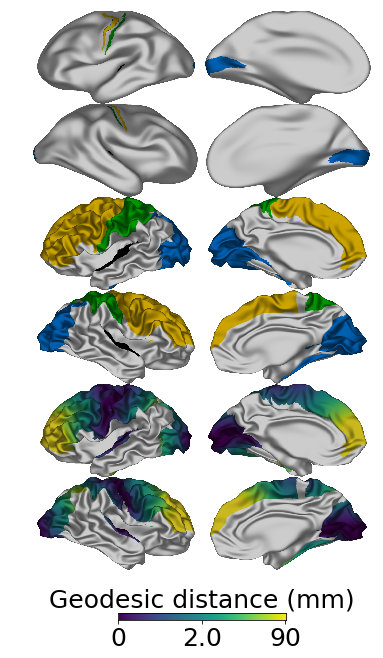

In [76]:
hemis=['left','right']
ncol=4
nrow=7
fig = plt.figure(figsize=(7, 12)) 
gs = gridspec.GridSpec(nrow, ncol, width_ratios=np.ones(ncol), #height_ratios=[1,0.1],
         wspace=0.05, hspace=0, left=0.17, right=0.845)
#gs.tight_layout(fig)

systems = ['auditory','visual','somatosensory','motor']

for k,hemi in enumerate(hemis):
    archi_mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/archi_'+hemi+'.txt')
    #primary first
    primary_overlay=np.zeros(163842)
    region_overlays=np.zeros(163842)
    for sys_num, system in enumerate(systems):
        primary_overlay+=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/geodesics/'+system[0]+'1_'+hemi+'.txt')[:163842]*(sys_num+1)
        region_overlays+=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/geodesics/'+system+'_regions_'+hemi+'.txt')[:163842]*(sys_num+1)
        
    surface_file='/data1/users/kwagstyl/bigbrain/orig/flatterwhite_'+hemi+'_327680.obj'
    surface_plots = plot_surface(primary_overlay, surface_file,'nipy_spectral',min_val=1, max_val=5)
    ax= plt.subplot(gs[k,2:4])
    ax.imshow(surface_plots[np.abs(k-1)])
    ax.axis('off')
    ax= plt.subplot(gs[k,0:2])
    ax.imshow(surface_plots[1-np.abs(k-1)])
    ax.axis('off')
    surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatwhite_'+hemi+'_327680.obj'

    surface_plots = plot_surface(region_overlays, surface_file,'nipy_spectral',min_val=1, max_val=5)
    ax= plt.subplot(gs[k+2,2:4])
    ax.imshow(surface_plots[np.abs(k-1)])
    ax.axis('off')
    ax= plt.subplot(gs[k+2,0:2])
    ax.imshow(surface_plots[1-np.abs(k-1)])
    ax.axis('off')
    
    overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/geodesics/all_systems_geodesic_distances_'+hemi+'.txt')[:163842]
    archi_mask[region_overlays==0]=1
    surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatwhite_'+hemi+'_327680.obj'
    dmin_val=0
    dmax_val=90
    surface_plots = plot_surface(overlay, surface_file,'viridis',mask=archi_mask, min_val=dmin_val, max_val=dmax_val, below_thresh=1)
    ax= plt.subplot(gs[k+4,2:4])
    ax.imshow(surface_plots[np.abs(k-1)])
    ax.axis('off')
    ax= plt.subplot(gs[k+4,0:2])
    ax.imshow(surface_plots[1-np.abs(k-1)])
    ax.axis('off')
    
ax= plt.subplot(gs[6,1:3])
bar=np.reshape(rgb_matrix('viridis'),(256,1,4))
bar=np.vstack(([[[1,1,1,1]]],bar))
bar=np.repeat(bar,10,axis=1)

ax.imshow(np.rot90(bar))
#ax.axis('off')
ax.set_yticks([])
ax.set_xticks([0,128,256])
ax.set_xticklabels([np.round(dmin_val,decimals=2),np.mean([dmin_val,max_val]),np.round(dmax_val,decimals=2)],size=25)
ax.set_title('Geodesic distance (mm)', size=25)

fig.savefig('/data1/users/kwagstyl/bigbrain/NeuralNetworks/figs/regions_total_thickness.pdf',bbox_inches='tight')

In [72]:
#surface_plots = plot_surface(overlay, surface_file,'magma',min_val=0, max_val=4)
print(sum(mask))
print(sum(1-mask))

80184
83658
